In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [52]:
marketing = pd.read_csv('Data/Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases',
       'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases',
       'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One',
       'Accept_Rate', 'Cust_Accept (%)'],
      dtype='object')

In [53]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 22 columns):
Age                    2223 non-null int64
Education              2223 non-null object
Relationship_Status    2223 non-null object
Income                 2223 non-null float64
Children               2223 non-null int64
Wine ($)               2223 non-null int64
Fruit ($)              2223 non-null int64
Meat ($)               2223 non-null int64
Fish ($)               2223 non-null int64
Sweets ($)             2223 non-null int64
Gold_Products ($)      2223 non-null int64
Total Spent ($)        2223 non-null int64
Discount_Purchases     2223 non-null int64
Web_Purchases          2223 non-null int64
Catalog_Purchases      2223 non-null int64
Store_Purchases        2223 non-null int64
Days_Enrolled          2223 non-null float64
Avg_Purch_Freq         2223 non-null float64
Avg_Spend ($)          2223 non-null float64
Accept_One             2223 non-null int64
Accept_Rate            

**Preprocessing for Customer Segmentation / Classification Below**

In [54]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])
ml.columns = ['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']

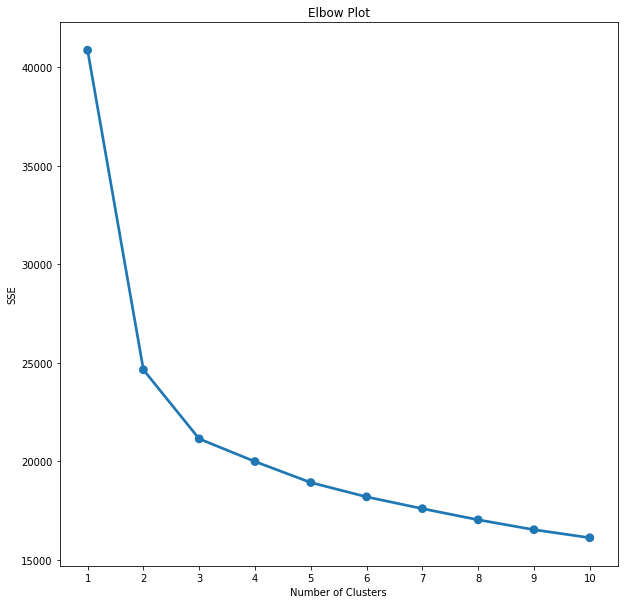

3 clusters looks optimal


In [55]:
from sklearn.cluster import KMeans
import seaborn as sns


X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Elbow Plot')
plt.show()
print('3 clusters looks optimal')

In [82]:
customer_clusters = pd.DataFrame(marketing[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)']])
### Frequency ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Purch_Freq']])
customer_clusters['FrequencyCluster'] = kmeans.predict(ml[['Avg_Purch_Freq']])
freq = customer_clusters.groupby('FrequencyCluster')[['Avg_Purch_Freq']].mean().sort_values('Avg_Purch_Freq', ascending=True).reset_index(drop=False)
# freq['FrequencyCluster'] = freq.index
freq


,FrequencyCluster,Avg_Purch_Freq
0,0,13.384433
1,1,32.967652
2,2,96.111263


In [81]:
## Value of each visit ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Spend ($)']])
customer_clusters['SpendCluster'] = kmeans.labels_
spend = customer_clusters.groupby('SpendCluster')[['Avg_Spend ($)']].mean().sort_values('Avg_Spend ($)', ascending=False).reset_index(drop=False)
# spend['SpendCluster'] = spend.index
spend

,SpendCluster,Avg_Spend ($)
0,0,72.666833
1,1,26.659581
2,2,7.726328


In [80]:
### Total Revenue ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Total Spent ($)']])
customer_clusters['RevenueCluster'] = kmeans.labels_
revenue = customer_clusters.groupby('RevenueCluster')[['Total Spent ($)']].mean().sort_values('Total Spent ($)', ascending=False).reset_index(drop=False)
# revenue['RevenueCluster'] = revenue.index
revenue

,RevenueCluster,Total Spent ($)
0,0,1207.000000
1,1,300.275605
2,2,50.792350


In [59]:
### Reassigning Cluster Values Before Giving Overall Score to Customers ###
for idx, row in customer_clusters.iterrows():
    if row['FrequencyCluster'] == freq.loc[0, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 0
    elif row['FrequencyCluster'] == freq.loc[1, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 1
    elif row['FrequencyCluster'] == freq.loc[2, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 2
    if row['SpendCluster'] == spend.loc[0, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 0
    elif row['SpendCluster'] == spend.loc[1, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 1
    elif row['SpendCluster'] == spend.loc[2, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 2
    if row['RevenueCluster'] == revenue.loc[0, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 0
    elif row['RevenueCluster'] == revenue.loc[1, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 1
    elif row['RevenueCluster'] == revenue.loc[2, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 2

### Calculating Each Customer's Overall Score ###
customer_clusters['Overall_Score'] = customer_clusters['FrequencyCluster'] + customer_clusters['SpendCluster'] + customer_clusters['RevenueCluster']
customer_clusters = customer_clusters.drop(['FrequencyCluster', 'SpendCluster', 'RevenueCluster'], axis=1)
customer_clusters.groupby('Overall_Score')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean()

,Avg_Purch_Freq,Avg_Spend ($),Total Spent ($),Accept_One,Cust_Accept (%)
Overall_Score,,,,,
0,13.342309,71.207550,1491.935897,0.547009,19.800570
1,24.640631,59.876261,1227.216981,0.428302,12.138365
2,23.839952,31.456801,641.983444,0.245033,6.181015
3,34.712721,21.665775,326.111486,0.206081,4.391892
4,52.901852,15.210619,157.304054,0.148649,2.927928
5,44.370824,8.660294,63.248963,0.145228,3.181189
6,101.568698,7.325148,45.415254,0.120763,2.471751


In [60]:
### Assigning Customer Value Groups ###
customer_clusters['Customer_Value'] = ''
for idx, row in customer_clusters.iterrows():
    if row['Overall_Score'] == 0 or row['Overall_Score'] == 1:
        customer_clusters.loc[idx, 'Customer_Value'] = 'High'
    if row['Overall_Score'] == 2 or row['Overall_Score'] == 3:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Medium'
    if row['Overall_Score'] == 4 or row['Overall_Score'] == 5 or row['Overall_Score'] == 6:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Low'
customer_clusters.drop('Overall_Score', axis=1)
print(customer_clusters['Customer_Value'].value_counts())

Low       861
High      764
Medium    598
Name: Customer_Value, dtype: int64


In [61]:
customer_clusters.groupby('Customer_Value')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Avg_Purch_Freq,Avg_Spend ($),Total Spent ($),Accept_One,Cust_Accept (%)
Customer_Value,,,,,
High,21.180150,63.346839,1308.295812,0.464660,14.485166
Medium,29.221791,26.610407,485.632107,0.225753,5.295429
Low,77.193110,9.054323,69.639954,0.132404,2.748742


In [62]:
pd.set_option('display.expand_frame_repr', False)

### Getting Purchase Channel Percentages and Product Percentages ###
customer_clusters['Total Purchases'] = customer_clusters['Discount_Purchases'] + customer_clusters['Web_Purchases'] + customer_clusters['Catalog_Purchases'] + customer_clusters['Store_Purchases']
for category in ['Discount_Purchases', 'Web_Purchases','Catalog_Purchases', 'Store_Purchases']:
    customer_clusters[category[:-10] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Purchases']) * 100
for category in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)','Gold_Products ($)']:
    customer_clusters[category[:-3] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Spent ($)']) * 100


customer_clusters.groupby('Customer_Value')['Age', 'Income', 'Children', 'Days_Enrolled', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Age,Income,Children,Days_Enrolled,Accept_One,Cust_Accept (%)
Customer_Value,,,,,,
High,46.725131,72333.340767,0.494764,436.540576,0.464660,14.485166
Medium,47.237458,53162.978290,1.088629,497.301003,0.225753,5.295429
Low,42.140534,32754.475097,1.261324,497.527294,0.132404,2.748742


In [63]:
customer_clusters.groupby('Customer_Value')['Wine  (%)', 'Fruit  (%)', 'Meat  (%)', 'Fish  (%)',
       'Sweets  (%)', 'Gold_Products  (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Wine (%),Fruit (%),Meat (%),Fish (%),Sweets (%),Gold_Products (%),Accept_One,Cust_Accept (%)
Customer_Value,,,,,,,,
High,50.085290,4.310314,28.610462,6.194738,4.547173,6.252023,0.464660,14.485166
Medium,53.516568,4.293118,21.213320,5.929793,4.228313,10.818889,0.225753,5.295429
Low,36.811064,5.931377,24.327950,8.845264,6.181877,17.902467,0.132404,2.748742


In [64]:
customer_clusters.groupby('Customer_Value')['Discount (%)', 'Web (%)', 'Catalog (%)',
       'Store (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Discount (%),Web (%),Catalog (%),Store (%),Accept_One,Cust_Accept (%)
Customer_Value,,,,,,
High,9.324511,26.230318,25.472909,38.972261,0.464660,14.485166
Medium,18.352325,30.598122,13.216972,37.832580,0.225753,5.295429
Low,25.736462,24.526019,4.952051,44.785468,0.132404,2.748742


Text(0.5, 1, 'Avg. Spend Per Purchase vs. Total Spent')

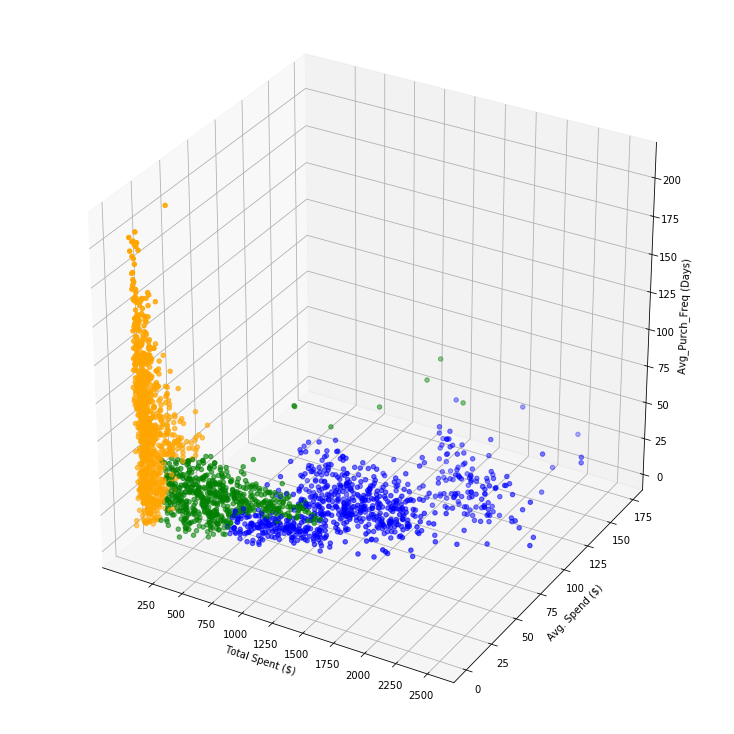

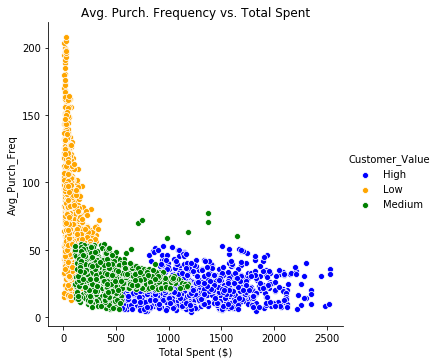

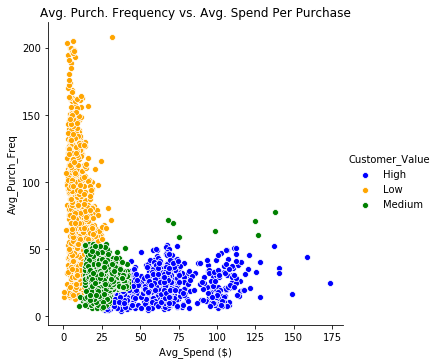

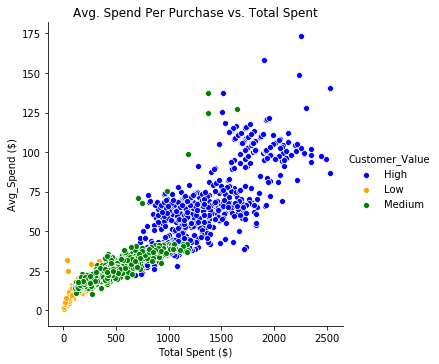

In [65]:
### Frequency vs Revenue ###
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10,10)

color = { 'High': 'blue', 'Medium': 'green', 'Low': 'orange'}

customer_clusters['colors'] = customer_clusters['Customer_Value'].replace({ 'High': 'blue', 'Medium': 'green', 'Low': 'orange'})

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_clusters['Total Spent ($)'], customer_clusters['Avg_Spend ($)'], customer_clusters['Avg_Purch_Freq'],
           c=customer_clusters['colors'])
ax.set_xlabel('Total Spent ($)')
ax.set_zlabel('Avg_Purch_Freq (Days)')
ax.set_ylabel('Avg. Spend ($)')
ax.set_xticks([250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500])

sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Total Spent')
sns.pairplot(x_vars=["Avg_Spend ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Avg. Spend Per Purchase')
sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Spend ($)"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Spend Per Purchase vs. Total Spent')




**Classification - 1)Predict Acceptance of one offer  2) Predict Likelihood Group (low/medium/high)**

**----------------------Imbalanced----------------------------**

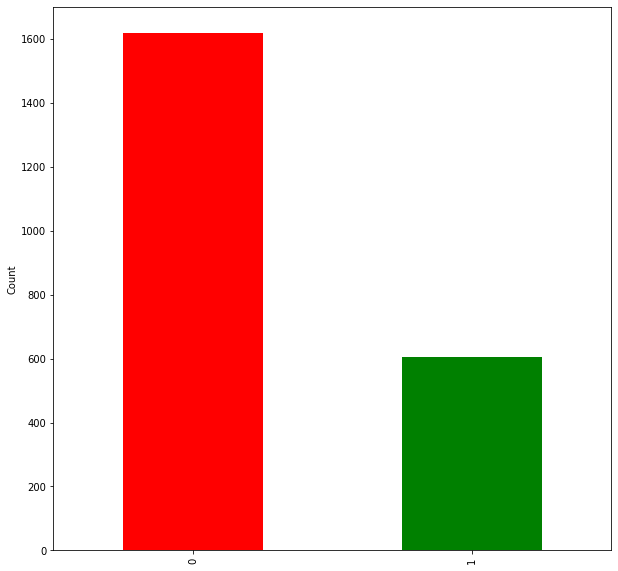

0    1619
1     604
Name: Accept_One, dtype: int64


In [66]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

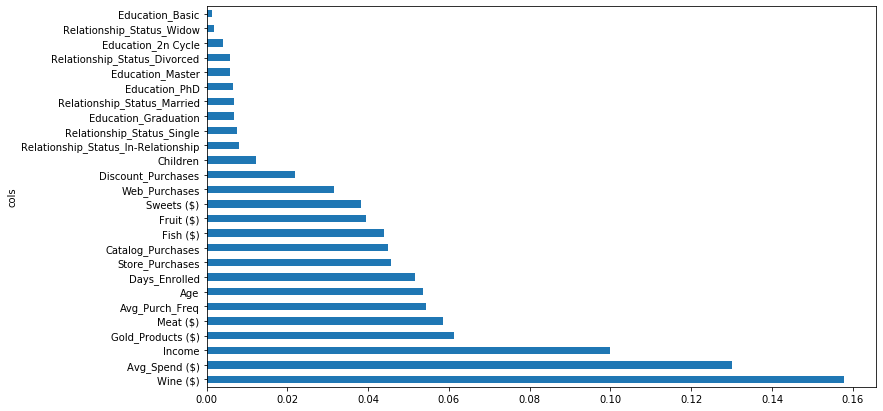


OOB Score:  0.794241151769646

Best Params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}

Testing Accuracy: 0.814748201438849
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       413
           1       0.71      0.48      0.57       143

    accuracy                           0.81       556
   macro avg       0.77      0.70      0.73       556
weighted avg       0.80      0.81      0.80       556

[[385  28]
 [ 75  68]]

ROC_AUC:  0.7038639326774919


In [67]:
### RandomForest ###

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

ml = ml.drop('Total Spent ($)', axis=1)
categorical = categorical.drop('Total Spent ($)', axis=1)
X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**Summary of XBG Hyperparameter tuning steps I took for each XGboost model**

In [68]:
### Gradient Boosting ####
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=.125, n_estimators=90, subsample=.8, max_features='sqrt', max_depth=5, min_samples_split=.85,
                    min_samples_leaf=25,random_state=27)
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

[11:52:20] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.8183453237410072
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       413
           1       0.70      0.51      0.59       143

    accuracy                           0.82       556
   macro avg       0.77      0.72      0.74       556
weighted avg       0.81      0.82      0.81       556

[[382  31]
 [ 70  73]]

ROC_AUC:  0.7177144889009296


**--------------------Undersampling----------------------------**

Using TensorFlow backend.


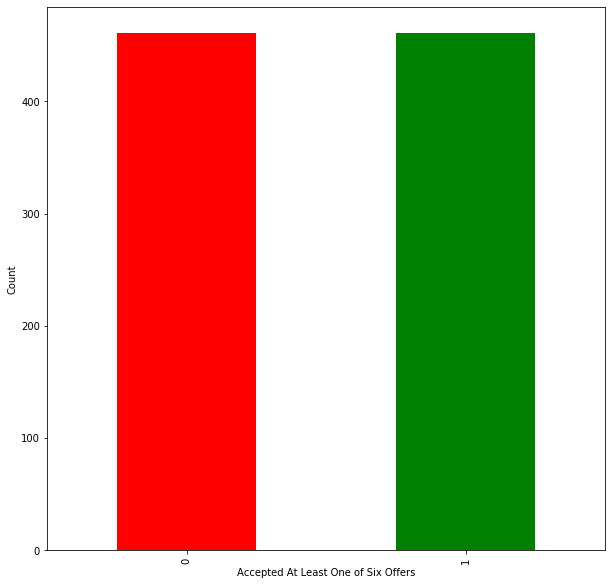

Acceptance Value Counts
1    461
0    461
dtype: int64


In [69]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
print('Acceptance Value Counts')
print(acceptance.value_counts())


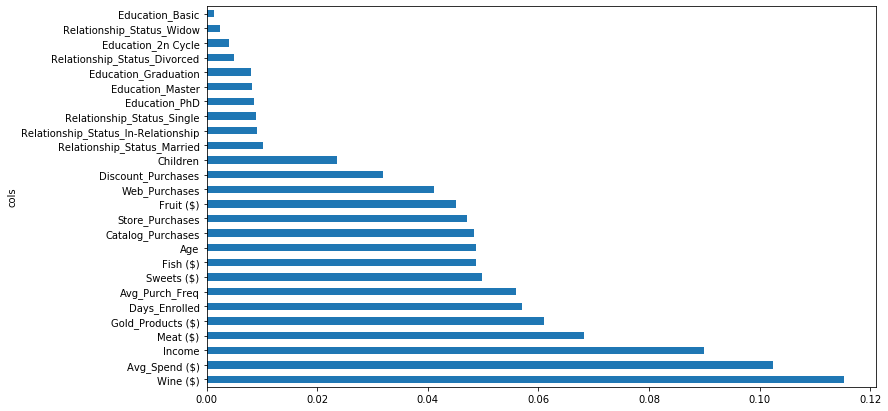


OOB Score:  0.7527114967462039

Best Params: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 600}

Testing Accuracy: 0.7841726618705036
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       413
           1       0.56      0.73      0.64       143

    accuracy                           0.78       556
   macro avg       0.73      0.77      0.74       556
weighted avg       0.81      0.78      0.79       556

[[331  82]
 [ 38 105]]

ROC_AUC:  0.7678592593846831


In [70]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [71]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier(learning_rate=.025, n_estimators=160, subsample=.75, max_features='sqrt', max_depth=12, min_samples_split=.82,
                    min_samples_leaf=50,random_state=27)
xgb.fit(X_resampled, y_resampled)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


[11:53:43] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.7805755395683454
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       413
           1       0.56      0.73      0.63       143

    accuracy                           0.78       556
   macro avg       0.73      0.76      0.74       556
weighted avg       0.81      0.78      0.79       556

[[330  83]
 [ 39 104]]

ROC_AUC:  0.7631521021351529


**-------------------Oversampling---------------------------------**

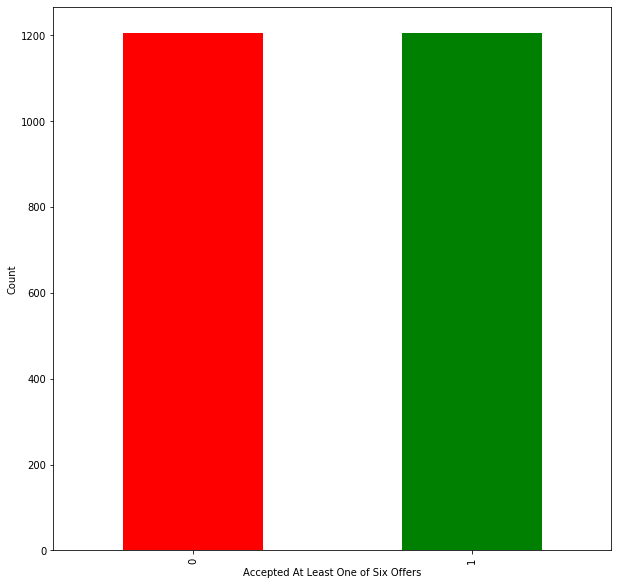

1    1206
0    1206
dtype: int64


In [72]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1, random_state=47)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

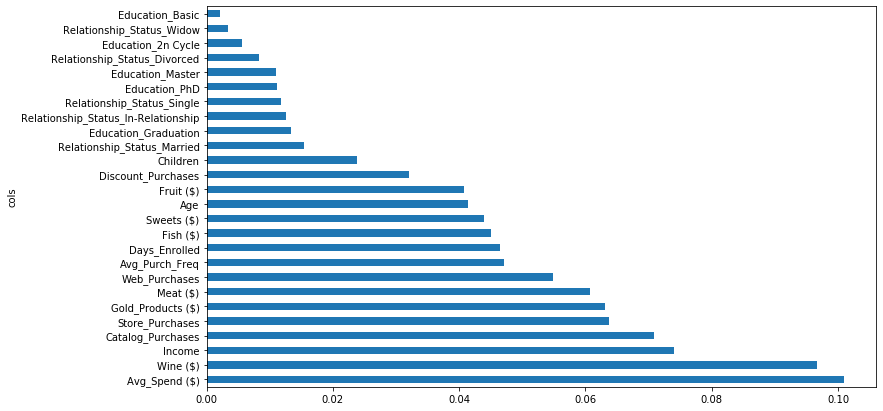


OOB Score:  0.8818407960199005

Best Params: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 400}

Testing Accuracy: 0.8255395683453237
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       413
           1       0.69      0.59      0.64       143

    accuracy                           0.83       556
   macro avg       0.78      0.75      0.76       556
weighted avg       0.82      0.83      0.82       556

[[374  39]
 [ 58  85]]

ROC_AUC:  0.7499873008347585


In [73]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)


plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

[11:57:11] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




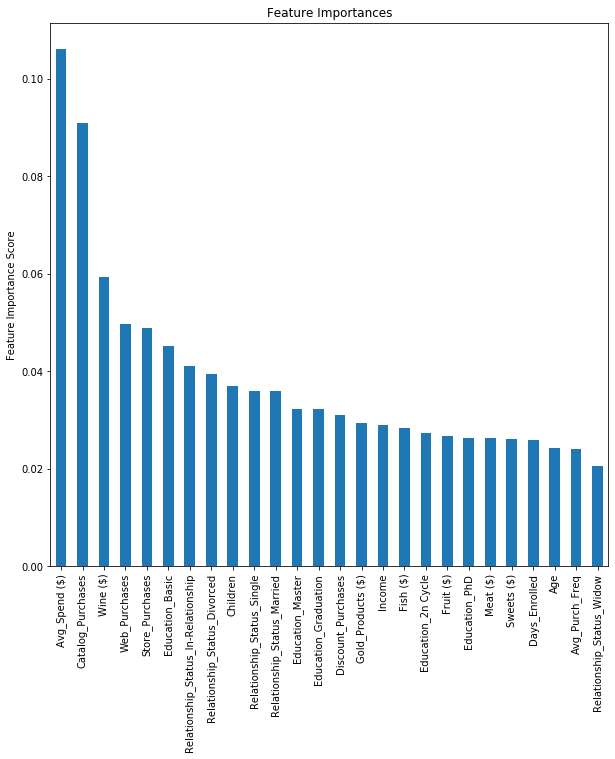


Testing Accuracy: 0.8237410071942446
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       413
           1       0.68      0.59      0.63       143

    accuracy                           0.82       556
   macro avg       0.77      0.75      0.76       556
weighted avg       0.82      0.82      0.82       556

[[373  40]
 [ 58  85]]

ROC_AUC:  0.7487766470817317


In [74]:
### Gradient Boost Classifier Using Oversampling ###
from xgboost import XGBClassifier


xgb = XGBClassifier(learning_rate = .0025, n_estimators = 1800, subsample=.8, max_features='sqrt', max_depth=18, min_samples_split=.224,
                    min_samples_leaf=40,random_state=27)
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

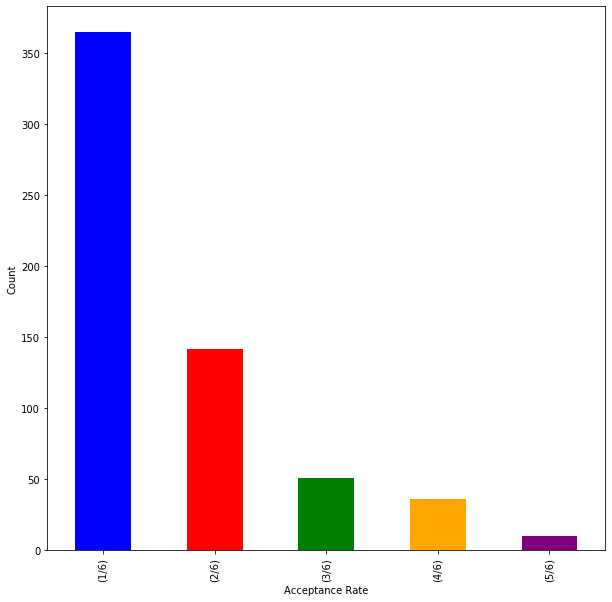

  Accept_Rate  # Customers
0       (1/6)          365
1       (2/6)          142
2       (3/6)           51
3       (4/6)           36
4       (5/6)           10


In [75]:
### Sclicing to only included customers who accepted at least one offer ###
marketing = pd.read_csv('Data/Cust_Records.csv')
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new.columns = ['Accept_Rate', '# Customers']
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(new)


**Will Split Acceptance Rate into THREE groups "Least Likely"(1 - Accept Only 1/6), "More Likely"(2 - Accept 2/6 or 3/6), "Most Likely" (3 - Accept 4/6 or 5/6). 

In [76]:
### Numerically Encoding the three likelihood groups ^ with Accept_Rate ###

for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '(1/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '(2/6)' or row['Accept_Rate'] == '(3/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '(4/6)' or row['Accept_Rate'] == '(5/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    
marketing_ml_accept = marketing_accept.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')

Imbalanced Multiclass Problem


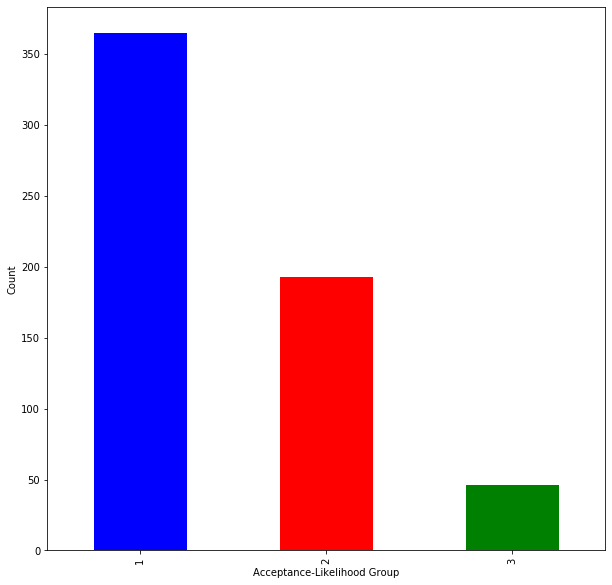

 Acceptance-Likelihood Group  # Customers
                           1          365
                           2          193
                           3           46

Oversampling


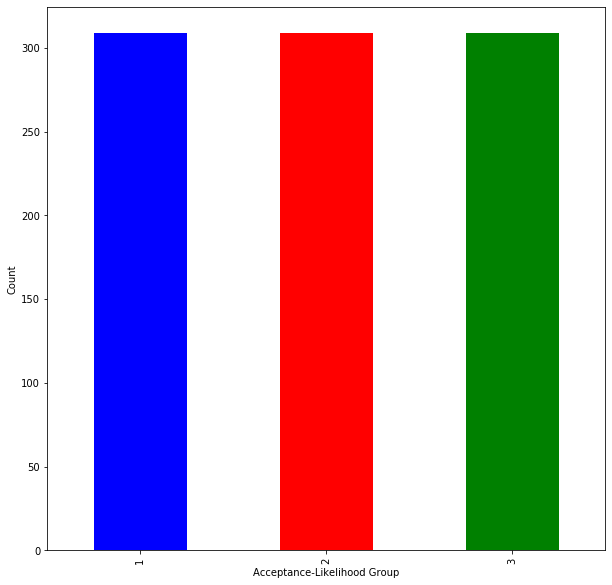

1    309
2    309
3    309
dtype: int64


In [77]:
### Classifier for Accept_Rate - Gradient Boosting ###

X = ml_accept.values
y = marketing_accept['Accept_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new.columns = ['Acceptance-Likelihood Group', '# Customers']
print('Imbalanced Multiclass Problem')
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance-Likelihood Group')
plt.ylabel('Count')
plt.show()
print(new.to_string(index=False))

### SMOTE - Oversampling ###
from imblearn.over_sampling import SMOTE
print('\nOversampling')
sm = SMOTE(n_jobs=-1, random_state=47)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().sort_index().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance-Likelihood Group')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts().sort_index())

In [78]:
### Gradient Boosting - Predicting Acceptance Likelihood Group (no hyperparameter tuning) ###

xgb = XGBClassifier()
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


Testing Accuracy: 0.6813186813186813
              precision    recall  f1-score   support

           1       0.80      0.77      0.78        56
           2       0.50      0.58      0.54        26
           3       0.57      0.44      0.50         9

    accuracy                           0.68        91
   macro avg       0.62      0.60      0.61        91
weighted avg       0.69      0.68      0.68        91

[[43 12  1]
 [ 9 15  2]
 [ 2  3  4]]


In [79]:
### Gradient Boosting - Predicting Acceptance Likelihood Group (hyperparameter tuning) ###


xgb = XGBClassifier(learning_rate=.005, n_estimators=1250, subsample=.75, max_features='sqrt', max_depth=22, min_samples_split=.524, num_class=3, objective='multi:softmax',
                    min_samples_leaf=25, random_state=27)
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

[11:57:28] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.7032967032967034
              precision    recall  f1-score   support

           1       0.81      0.84      0.82        56
           2       0.57      0.50      0.53        26
           3       0.40      0.44      0.42         9

    accuracy                           0.70        91
   macro avg       0.59      0.59      0.59        91
weighted avg       0.70      0.70      0.70        91

[[47  7  2]
 [ 9 13  4]
 [ 2  3  4]]
